# Creating a csv file that stores filenames, classes and source for mask classification network


In [1]:
# creating categories for dataset
import os, csv

base_path = os.getcwd()
mask_categories = ["cloth_mask", "N-95_Mask", "no_mask", "surgical_mask", "wrong_worn_mask"]
# categories_size = [0, 0, 0, 0, 0]
dataset_csv = os.path.join(base_path, "dataset.csv")
with open(dataset_csv, 'w+') as file:
    writer=csv.writer(file)
    writer.writerow(["", "filename", "Category"])
    for dataset_path, dataset_dirs, dataset_files in os.walk(os.path.join(base_path, "dataset")):
        for category_index, mask_category in enumerate(mask_categories):
            counter = 0
            for category_path, category_dirs, category_files in os.walk(os.path.join(dataset_path, mask_category)):
                for file in category_files:
                    writer.writerow([counter, os.path.join(category_path, file), category_index])
                    counter += 1

# csv file has the following columns:
# 0: index
# 1: filename
# 2: category

In [2]:
pip install pandas


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [11]:
#pip install pandas
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [9]:
data_path = os.path.join(base_path, "dataset.csv")
img_path = os.path.join(base_path, "dataset", "")

400
400
400
400
400


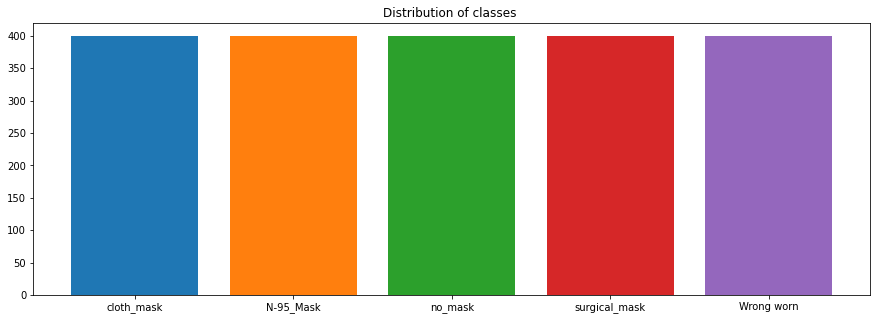

In [44]:
cloth_path="C:/Users/Waleed/Downloads/Code/dataset/cloth_mask"
cloth_mask_len= len(os.listdir(cloth_path))

N_95_Mask_path="C:/Users/Waleed/Downloads/Code/dataset/N-95_Mask"
N_95_Mask_len= len(os.listdir(N_95_Mask_path))

no_mask_path="C:/Users/Waleed/Downloads/Code/dataset/no_mask"
no_mask_len= len(os.listdir(no_mask_path))

surgical_mask_path="C:/Users/Waleed/Downloads/Code/dataset/surgical_mask"
surgical_mask_len= len(os.listdir(surgical_mask_path))

wrong_worn_mask_path="C:/Users/Waleed/Downloads/Code/dataset/wrong_worn_mask"
wrong_worn_mask_len= len(os.listdir(wrong_worn_mask_path))

print(cloth_mask_len)
print(N_95_Mask_len)
print(no_mask_len)
print(surgical_mask_len)
print(wrong_worn_mask_len)


plt.title('Distribution of classes ')
plt.rcParams["figure.figsize"] = (15, 5)
plt.bar("cloth_mask", cloth_mask_len)
plt.bar("N-95_Mask", N_95_Mask_len)
plt.bar("no_mask", no_mask_len)
plt.bar("surgical_mask", surgical_mask_len)
plt.bar("Wrong worn", wrong_worn_mask_len)

plt.show()

# Loading Data

In [10]:
import os
from torch.utils.data import Dataset
from PIL import Image

class MaskImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, index): # index is the row number
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[index, 1])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[index, 2]
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [45]:
#Dimension of each image -> 224* 224
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(), # tensor means convert to numpy array
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ]) # 0.485, 0.456, 0.406 is the mean of ImageNet dataset
                                # 0.229, 0.224, 0.225 is the std of ImageNet dataset

full_dataset = MaskImageDataset(data_path, img_path, transform=transform)


2000


In [14]:
train_size = int(0.75 * len(full_dataset)) # 75% of the dataset is used for training
test_size = len(full_dataset) - train_size # 25% of the dataset is used for testing
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])


In [46]:
train_data = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=32, shuffle=True)
print(len(train_data))

47


# Creating Training Model

In [16]:
from torch.nn import Conv2d, Linear, MaxPool2d, Module, BatchNorm2d
from torch.nn import functional as F

class MaskNetV2(Module):
    
    def __init__(self):
        ''' Initializing the model'''
        super(MaskNetV2, self).__init__()
        
        self.conv1 = Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=2)
        self.bn_1 = BatchNorm2d(32) # batch normalization makes the network more robust to variations in the input data
        
        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=2) 
        self.bn_2 = BatchNorm2d(64)
        
        self.conv3 = Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=2)
        self.bn_3 = BatchNorm2d(128)
        
#         self.conv4 = Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=2)
#         self.bn_4 = BatchNorm2d(256)
        
        self.maxpool = MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = Linear(2048, 256)
        self.fc2 = Linear(256, 64)
        self.fc3 = Linear(64, 5)
        
        
    def forward(self, x):
        
        x = F.relu(self.bn_1(self.conv1(x)), inplace=True) # relu is good for non-linear activation
        x = self.maxpool(x) # maxpool is good for downsampling
        
        x = F.relu(self.bn_2(self.conv2(x)), inplace=True)
        x = self.maxpool(x)
        
        x = F.relu(self.bn_3(self.conv3(x)), inplace=True)
        x = self.maxpool(x)
        
#         x = F.relu(self.bn_4(self.conv4(x)), inplace=True)
#         x = self.maxpool(x)
        
        # Flattening layer followed by the convolutional neural network
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x), inplace=True)
        x = F.dropout(x, 0.3, training=self.training) # dropout is good for regularization
        
        x = F.relu(self.fc2(x), inplace=True)
        x = F.dropout(x, 0.3, training=self.training)
        
        x = self.fc3(x)
        return x

In [17]:
model = MaskNetV2()
print(model)

MaskNetV2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (bn_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (bn_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)


Creating two variants of the above model - one without any padding and one without any pooling

In [ ]:
class VariantWithoutPadding(Module):
    
    def __init__(self):
        ''' Initializing the model'''
        super(VariantWithoutPadding, self).__init__()
        
        self.conv1 = Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=0)
        self.bn_1 = BatchNorm2d(32)
        
        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=0)
        self.bn_2 = BatchNorm2d(64)
        
        self.conv3 = Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=0)
        self.bn_3 = BatchNorm2d(128)
        
#         self.conv4 = Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=0)
#         self.bn_4 = BatchNorm2d(256)
        
        self.maxpool = MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = Linear(1152, 256) 
        self.fc2 = Linear(256, 64)
        self.fc3 = Linear(64, 5)
        
        
    def forward(self, x):
        
        x = F.relu(self.bn_1(self.conv1(x)), inplace=True) # relu is used to prevent the negative values
        x = self.maxpool(x) # maxpool is used to reduce the size of the input for the next layer
        
        x = F.relu(self.bn_2(self.conv2(x)), inplace=True)
        x = self.maxpool(x)
        
        x = F.relu(self.bn_3(self.conv3(x)), inplace=True)
        x = self.maxpool(x)
        
#         x = F.relu(self.bn_4(self.conv4(x)), inplace=True)
#         x = self.maxpool(x)
        
        # Flattening layer followed by the convulation network
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x), inplace=True)
        x = F.dropout(x, 0.3, training=self.training) # dropout is used to prevent overfitting
        
        x = F.relu(self.fc2(x), inplace=True)
        x = F.dropout(x, 0.3, training=self.training) # dropout is used to prevent overfitting
        
        x = self.fc3(x)
        return x

In [ ]:
variant_without_padding = VariantWithoutPadding()
print(variant_without_padding)

variant_without_padding = variant_without_padding.to(device)
print(device)

In [ ]:
class VariantWithoutPooling(Module):
    
    def __init__(self):
        ''' Initializing the model'''
        super(VariantWithoutPooling, self).__init__()
        
        self.conv1 = Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=2)
        self.bn_1 = BatchNorm2d(32) # batch normalization is used to prevent the network from overfitting
        
        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=2) 
        self.bn_2 = BatchNorm2d(64)
        
        self.conv3 = Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=2)
        self.bn_3 = BatchNorm2d(128)
        
#         self.conv4 = Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=2)
#         self.bn_4 = BatchNorm2d(256)
        
        self.fc1 = Linear(115200, 4096) # 115200 is the number of features after the convolutional neural network
        self.fc2 = Linear(4096, 512)
        self.fc3 = Linear(512, 5)
        
        
    def forward(self, x):
        
        x = F.relu(self.bn_1(self.conv1(x)), inplace=True) # relu is used to prevent the negative values
        
        x = F.relu(self.bn_2(self.conv2(x)), inplace=True)
        
        x = F.relu(self.bn_3(self.conv3(x)), inplace=True)
        
#         x = F.relu(self.bn_4(self.conv4(x)), inplace=True)
        
        # Flattening layer followed by the fourth convulation network
        x = x.view(x.size(0), -1) 
        
        x = F.relu(self.fc1(x), inplace=True)  
        x = F.dropout(x, 0.3, training=self.training) # dropout is used to prevent overfitting
        
        x = F.relu(self.fc2(x), inplace=True)
        x = F.dropout(x, 0.3, training=self.training)
        
        x = self.fc3(x)
        return x

In [ ]:
variant_without_pooling = VariantWithoutPooling()
print(variant_without_pooling)

variant_without_pooling = variant_without_pooling.to(device)
print(device)

# Training Model

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device) # model is moved to the GPU if available
print(device)

In [ ]:
import time
def trainModel(model, model_name, train_loader, device):
    learning_rate = 0.001
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr = learning_rate)
    
    train_losses = []
    acc_list = []
    epochs = 45
    
    for i in range(1, epochs+1): 
        start = time.time()
        
        running_loss = 0.0
        total = 0
        correct = 0
        
        for j, data in enumerate(train_loader, 0):
            
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad() # optimizer is set to zero before the forward pass
            outputs = model(inputs) # forward pass
            
            loss = criterion(outputs, labels) # loss is calculated
            loss.backward() # loss is backpropagated
            optimizer.step() # optimizer is updated
            
            running_loss += loss.item() # loss is added to the running loss
            
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1) # predicted is the index of the maximum value in the output
            correct += (predicted == labels).sum().item()  # correct is the number of correct predictions
        
        train_loss = running_loss/len(train_loader.sampler) # loss is divided by the number of samples in the training set
        train_losses.append(train_loss) 
        accuracy = (correct / total) * 100 # accuracy is calculated
        acc_list.append(accuracy)
        
        print('Epoch: {} \tTraining Loss: {:.6f} \tAccuracy: {:.6f}'.format(
        i, train_loss, accuracy))
        elapsed = time.time() - start
        print("Elapsed time: " + time.strftime("%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:11], time.gmtime(elapsed)))
    
    print("Finished Training")
    torch.save(model.state_dict(), os.path.join(base_path, "saved_models\\" + model_name + ".pt"))
    torch.save(model, os.path.join(base_path, "saved_models\\" + model_name + "full.pt"))


In [ ]:
# trainModel(model, train_data, device)

In [ ]:
# variant_without_padding = VariantWithoutPadding()
# variant_without_pooling = VariantWithoutPooling()
# print(variant_without_padding)
# print(variant_without_pooling)

# variant_without_padding = variant_without_padding.to(device)
# variant_without_pooling = variant_without_pooling.to(device)
# print(device)

In [ ]:
trainModel(model, "CNN Model with padding and pooling", train_data, device) 
trainModel(variant_without_padding, "CNN Model without padding", train_data, device)
trainModel(variant_without_pooling, "CNN Model without pooling", train_data, device)


# Model Evalution

In [ ]:
import torch
from torch.utils.data import  DataLoader,random_split
from torchvision import datasets,transforms
import torch.nn as nn

import numpy as np

import matplotlib.pyplot as plt

data_path = os.path.join(base_path, "dataset.csv")
img_path = os.path.join(base_path, "dataset", "")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 
#device = torch.device('cpu')

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

full_dataset = MaskImageDataset(data_path, img_path, transform=transform) 

train_size = int(0.75 * len(full_dataset)) 
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
#train_data = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=32, shuffle=True)

the_model = MaskNetV2() 
the_model = the_model.to(device)
path = os.path.join(base_path, "saved_models\\CNN Model with padding and poolingfull.pt")
the_model=torch.load(path)

## Test Accuracy

In [ ]:
from torch.nn.functional import cross_entropy
def test_model(model,testing_data,DEVICE):
      
    testing_loss = 0
    correct_prediction = 0 
    data_size = 0
    prediction1=[]
    for images, labels in testing_data:
            images = images.to(device)
            labels = labels.to(device)          
            data_size += len(images)
            prediction = model(images) 
            
            prediction1.append(prediction)
            
            testing_loss += cross_entropy(prediction, labels).item()
            correct_prediction += (prediction.argmax(dim=1) == labels).sum().item()


    accuracy = correct_prediction/data_size
    testing_loss = testing_loss/data_size

    print('\nTesting:')
    print(f"Correct prediction: {correct_prediction}/{data_size} and accuracy: {accuracy} and loss: {testing_loss}")

In [ ]:
torch.cuda.empty_cache()
test_model(the_model,test_data,device)
torch.cuda.empty_cache()
test_model(variant_without_padding,test_data,device)
torch.cuda.empty_cache()
test_model(variant_without_pooling,test_data,device)

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def get_labels_N_prediction(model,loader,DEVICE):
    all_labels = []
    all_prediction = []

    for batch in loader:
        images, labels = batch
        images = images.to(DEVICE)

        prediction = model(images).to(torch.device("cpu")).argmax(dim=1).detach().numpy() 
        labels = labels.to(torch.device("cpu")).detach().numpy() 

        all_prediction = np.append(all_prediction,prediction)
        all_labels = np.append(all_labels,labels)

    return [all_labels,all_prediction]
# Evaluation
with torch.no_grad():
    labels_N_prediction = get_labels_N_prediction(the_model, test_data, device)
    
print(classification_report(labels_N_prediction[0], labels_N_prediction[1]))
conf_matrix = confusion_matrix(labels_N_prediction[0], labels_N_prediction[1]) 
print(conf_matrix)

print("Confusion matrices for variant without padding->")
with torch.no_grad():
    labels_N_prediction_variant_1 = get_labels_N_prediction(variant_without_padding, test_data, device)
    
print(classification_report(labels_N_prediction_variant_1[0], labels_N_prediction_variant_1[1]))
conf_matrix = confusion_matrix(labels_N_prediction_variant_1[0], labels_N_prediction_variant_1[1])
print(conf_matrix)

print("Confusion matrices for variant without pooling->")
with torch.no_grad():
    labels_N_prediction_variant_2 = get_labels_N_prediction(variant_without_pooling, test_data, device)
    
print(classification_report(labels_N_prediction[0], labels_N_prediction[1]))
conf_matrix = confusion_matrix(labels_N_prediction_variant_2[0], labels_N_prediction_variant_2[1])
print(conf_matrix)

## Accuracy Score

In [ ]:
#%%
import pandas as pd
#ACCURACY SCORE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib
#y_pred = the_model.predict(test_dataset)
y_pred =labels_N_prediction[1]  
y_test =labels_N_prediction[0] 
print("Accuracy of CNN Model with padding and pooling : ",accuracy_score(y_test, y_pred))

y_pred_variant_1 =labels_N_prediction_variant_1[1]
y_test_variant_1 =labels_N_prediction_variant_1[0]
print("Accuracy of CNN Model variant without padding : ",accuracy_score(y_test_variant_1, y_pred_variant_1))

y_pred_variant_2 =labels_N_prediction_variant_2[1]
y_test_variant_2 =labels_N_prediction_variant_2[0]
print("Accuracy of CNN Model variant without pooling : ",accuracy_score(y_test_variant_2, y_pred_variant_2))

## Precision, Recal, FScore, Support

In [ ]:
#PRECISION , RECALL,FSCORE,SUPPORT
from sklearn.metrics import precision_recall_fscore_support
d=()
d=precision_recall_fscore_support(labels_N_prediction[0], y_pred)
prec = d[0].tolist()
recall = d[1].tolist()
fscore = d[2].tolist()
support = d[3].tolist()
#precision_recall_fscore_support(y_test, y_pred,average="macro")
print("prec --",prec)
print("recall --",recall)
print("fscore --",fscore)
print("support --",support)

print("for variant 1 ->")
d_variant_1=()
d_variant_1=precision_recall_fscore_support(labels_N_prediction_variant_1[0], y_pred_variant_1)
prec_variant_1 = d_variant_1[0].tolist()
recall_variant_1 = d_variant_1[1].tolist()
fscore_variant_1 = d_variant_1[2].tolist()
support_variant_1 = d_variant_1[3].tolist()
print("prec --",prec_variant_1)
print("recall --",recall_variant_1)
print("fscore --",fscore_variant_1)
print("support --",support_variant_1)

print("for variant 2 ->")
d_variant_2=()
d_variant_2=precision_recall_fscore_support(labels_N_prediction_variant_2[0], y_pred_variant_2)
prec_variant_2 = d_variant_2[0].tolist()
recall_variant_2 = d_variant_2[1].tolist()
fscore_variant_2 = d_variant_2[2].tolist()
support_variant_2 = d_variant_2[3].tolist()
print("prec --",prec_variant_2)
print("recall --",recall_variant_2)
print("fscore --",fscore_variant_2)
print("support --",support_variant_2)

## Classification Report

In [ ]:
pip install seaborn

In [ ]:
#CLASSIFICATION REPORT - PRECISION , RECALL,FSCORE,SUPPORT
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

#PLOTTING CLASSIFICATION REPORT
import seaborn as sns
from pylab import savefig
h= classification_report(y_test, y_pred , output_dict=True)
svm =sns.heatmap(pd.DataFrame(h).iloc[:-1, :].T, annot=True)
figure = svm.get_figure()

figure.savefig('Classification report.png')

#CONFUSION MATRIX & PLOTTING IT
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(y_test, y_pred).tolist()
cm = sns.heatmap(confusion_matrix, annot=True, fmt='d')


cm.plot()
matplotlib.pyplot.show()
matplotlib.pyplot.savefig('confusion metrics.png')

#PLOTTING PRECISION AND RECALL GRAPH
from sklearn.metrics import PrecisionRecallDisplay

disp = PrecisionRecallDisplay(precision=precision_recall_fscore_support(y_test, y_pred)[0],recall=precision_recall_fscore_support(y_test, y_pred)[1])
disp.plot()
matplotlib.pyplot.show()
matplotlib.pyplot.savefig('Precision vs Recall.png')


# For Variant 1
#PLOTTING CLASSIFICATION REPORT
h_variant_1= classification_report(y_test, y_pred_variant_1 , output_dict=True)
svm_variant_1 =sns.heatmap(pd.DataFrame(h_variant_1).iloc[:-1, :].T, annot=True)
figure_variant_1 = svm_variant_1.get_figure()
figure_variant_1.savefig('Classification report_variant_1.png')

#CONFUSION MATRIX & PLOTTING IT
# confusion_matrix_variant_1 = confusion_matrix(y_test, y_pred_variant_1).tolist()
# cm_variant_1 = sns.heatmap(confusion_matrix_variant_1, annot=True, fmt='d')


# cm_variant_1.plot()
# matplotlib.pyplot.show()
# matplotlib.pyplot.savefig('confusion metrics_variant_1.png')

# #PLOTTING PRECISION AND RECALL GRAPH
# disp_variant_1 = PrecisionRecallDisplay(precision=precision_recall_fscore_support(y_test_variant_1, y_pred_variant_1)[0],recall=precision_recall_fscore_support(y_test_variant_1, y_pred_variant_1)[1])
# disp_variant_1.plot()
# matplotlib.pyplot.show()
# matplotlib.pyplot.savefig('Precision vs Recall_variant_1.png')



# For Variant 2
#PLOTTING CLASSIFICATION REPORT
h_variant_2= classification_report(y_test, y_pred_variant_2 , output_dict=True)
svm_variant_2 =sns.heatmap(pd.DataFrame(h_variant_2).iloc[:-1, :].T, annot=True)
figure_variant_2 = svm_variant_2.get_figure()
figure_variant_2.savefig('Classification report_variant_2.png')

# Testing trained model on new Image

## Loading saved trained model

In [ ]:
model = torch.load(os.path.join(base_path, "saved_models\\CNN Model with padding and poolingfull.pt"))

In [ ]:
import torch

from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def predictImage(model, imagePath, device, labels={0:'cloth', 1:'N95', 2:'No Mask', 3:'Surgical', 4:'Worn Wrong'}):
    
    
    transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])
    image = Image.open(imagePath).convert('RGB')
    imageD = Image.open(imagePath).convert('RGB')
    
    image = transform(image)
    
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image.unsqueeze(0))
    pred = list(output.argmax(dim=1).cpu().numpy())
    #print(pred)
    
    plt.imshow(imageD)    
    print("Prediction : " + labels[pred[0]])

In [ ]:
predictImage(model, os.path.join(base_path, "try1.jpg"), "cpu")

In [ ]:
print(model)